In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [2]:
# data
df = pd.read_csv("./data/building1retail.csv", index_col=0,
                 date_parser=lambda x: datetime.strptime(x, "%m/%d/%Y %H:%M"))
df.head()

,OAT (F),Power (kW)
Timestamp,,
2010-01-01 01:15:00,51,165.1
2010-01-01 01:30:00,51,151.6
2010-01-01 01:45:00,51,146.9
2010-01-01 02:00:00,51,153.7
2010-01-01 02:15:00,51,153.8


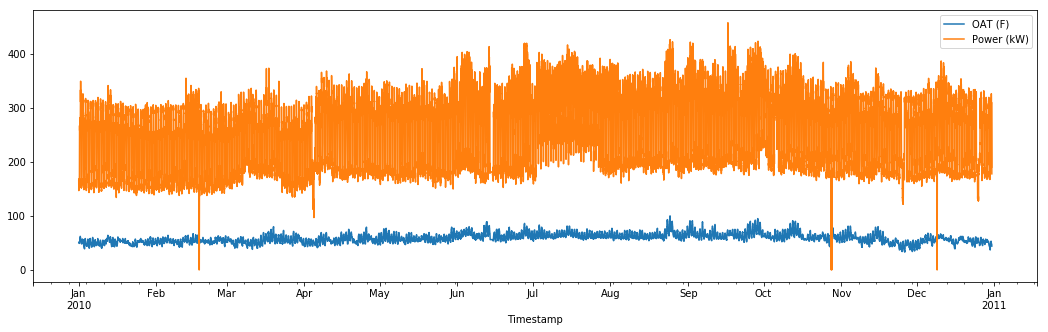

In [4]:
df.plot(figsize=(18,5))
plt.show()

In [5]:
# sanity check for missing values
df.isnull().values.any()

False

### In the plot there are downward long spikes visible. Let's verify these outliers.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f63f79b1da0>,
      dtype=object)

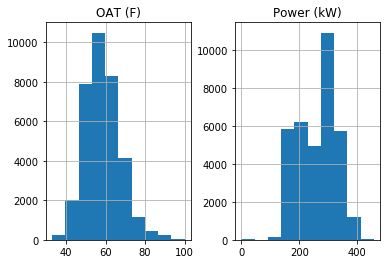

In [6]:
df.hist()

In [14]:
power = df['Power (kW)'].values
power[:10]

array([165.1, 151.6, 146.9, 153.7, 153.8, 159. , 157.7, 163.2, 151.7,
       148.7])

In [17]:
# standard deviation
print(f"Standard Deviation: {np.std(power)}")
print(f"3 * std: {3 * np.std(power)}")

Standard Deviation: 65.67245187390324
3 * std: 197.01735562170973


In [20]:
# z-score (number of std dev from the mean a data point is)
zscore = np.abs(stats.zscore(df))
zscore

array([[0.86800469, 1.47009373],
       [0.86800469, 1.67565937],
       [0.86800469, 1.74722667],
       ...,
       [1.6689909 , 0.84882866],
       [1.6689909 , 1.10007556],
       [1.6689909 , 1.27518704]])

In [22]:
# one way to remove outliers from data is remove all values that have z-score greater than 3
cut_off = 3
df = df[(zscore < float(cut_off)).all(axis=1)]
df.shape

(34577, 2)

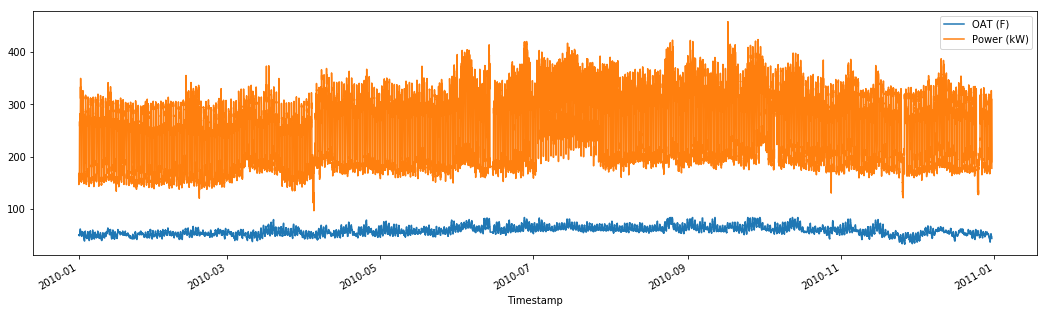

In [24]:
# verify the results
df.plot(figsize=(18,5))

great! spikes are contained...

In [25]:
df.columns

Index(['OAT (F)', 'Power (kW)'], dtype='object')

[]

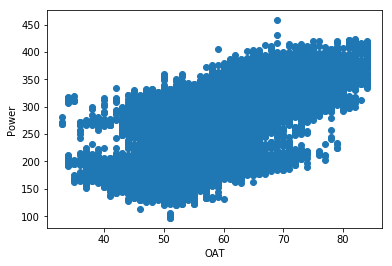

In [27]:
# validate relationship among features
plt.scatter(df['OAT (F)'], df['Power (kW)'])
plt.xlabel("OAT")
plt.ylabel("Power")
plt.plot()

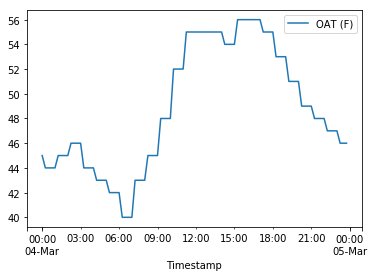

In [28]:
# verify timezone
# pick random day
df.loc['2010-03-04', ['OAT (F)']].plot();

OAT starts rising from sunrise and falls after sunset, sufficient enough to infer that data contains local timezone. Since building is in *Fremont, CA, USA* timezone must be Pacific Time.

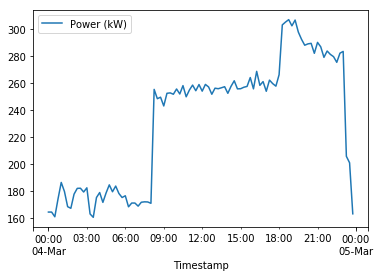

In [29]:
# let's plot the power of the building on the same day.
df.loc['2010-03-04', ['Power (kW)']].plot();

Power increase during 0900 hrs - 2330 hrs is visible(probably the building opening hours...)

In [30]:
X = df['OAT (F)'].values
y = df['Power (kW)'].values

# verify the size
print(f"X size: {X.size}\ny size: {y.size}")

X size: 34577
y size: 34577


In [34]:
# Linear Regression
X = X.reshape(-1, 1)
y = y.reshape(-1, 1)
model = LinearRegression()
scores = []
kfold = KFold(n_splits=3, shuffle=True, random_state=42)
for i, (train, test) in enumerate(kfold.split(X, y)):
    model.fit(X[train], y[train])
    score = model.score(X[test], y[test])
    scores.append(score)
print(f"Scores: {scores}")


Scores: [0.38768927735902686, 0.3852220878090442, 0.3845165478148713]


Certainly the scores doesn't look good...

### How can we improve the model?

Random day we picked earlier showed that power consumption is up during certain hours of the day.
Let's take another random day to see whether it's a trend...

In [35]:
from datetime import datetime as dt

In [37]:
dt(2010, 4, 14).weekday()

2

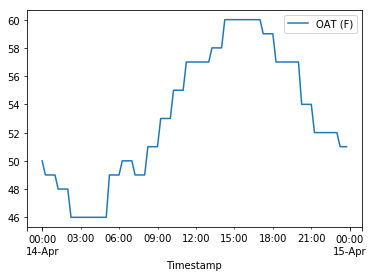

In [38]:
# its Wednesday...let's see the plot
df.loc['2010-04-14', ['OAT (F)']].plot();

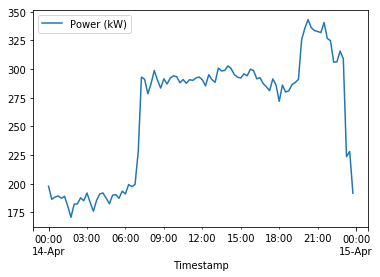

In [39]:
df.loc['2010-04-14', ['Power (kW)']].plot();

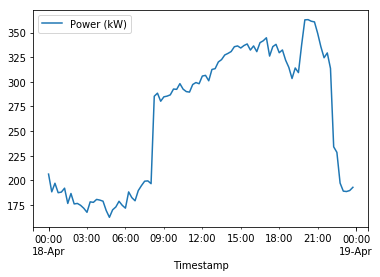

In [40]:
# what about weekend's
df.loc['2010-04-18', ['Power (kW)']].plot();

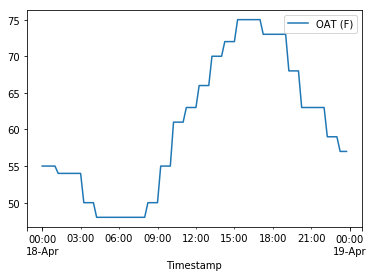

In [41]:
df.loc['2010-04-18', ['OAT (F)']].plot();

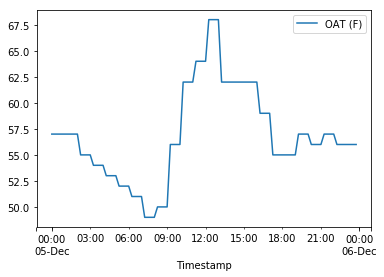

In [42]:
# and cool seasons...
df.loc['2010-12-05', ['OAT (F)']].plot();

Now there is some pattern in warm and cool seasons and time of the day...

Power (target variable) is highly dependant on OAT (outdoor air temp).

### One-hot encoding

In [45]:
# OAT variable is ordinal variable (natural ordering) 
X = pd.DataFrame(df['OAT (F)'])
y = pd.DataFrame(df['Power (kW)'])
X['tod'] = X.index.hour
add_var = pd.get_dummies(X['tod'], prefix='tod', drop_first=True)  # drop_first=True to remove multi-collinearity

# join all the columns to the model data
X = X.join(add_var)
# Drop the original column that was expanded
X.drop(columns=['tod'], inplace=True)
X.head()

,OAT (F),tod_1,tod_2,tod_3,tod_4,tod_5,tod_6,tod_7,tod_8,tod_9,...,tod_14,tod_15,tod_16,tod_17,tod_18,tod_19,tod_20,tod_21,tod_22,tod_23
Timestamp,,,,,,,,,,,,,,,,,,,,,
2010-01-01 01:15:00,51,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-01-01 01:30:00,51,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-01-01 01:45:00,51,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-01-01 02:00:00,51,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-01-01 02:15:00,51,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
# Now let's do regression again, this time it's multiple-regression.
model = LinearRegression()
scores = []
kfold = KFold(n_splits=3, shuffle=True, random_state=42)
for i, (train, test) in enumerate(kfold.split(X, y)):
    model.fit(X.iloc[train,:], y.iloc[train,:])
    scores.append(model.score(X.iloc[test,:], y.iloc[test,:]))
print(f"Scores: {scores}")

Scores: [0.8074246958895389, 0.8139449185141594, 0.8111379602960773]


###  What a big change in scores...